# Evaluate ICL Model on the MNIST Classification Dataset

## Imports

In [1]:
from jaxl.constants import *
from jaxl.datasets import get_dataset
from jaxl.datasets.wrappers import (
    ContextDataset,
    StandardSupervisedDataset,
    FixedLengthContextDataset,
    RepeatedContextDataset,
)
from jaxl.models import load_config, load_model, get_model, get_activation
from jaxl.plot_utils import set_size
from jaxl.utils import parse_dict, get_device

import _pickle as pickle
import copy
import jax
import jax.random as jrandom
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import torchvision.datasets as torch_datasets

from collections import OrderedDict
from functools import partial
from orbax.checkpoint import PyTreeCheckpointer, CheckpointManager
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader, SequentialSampler
from types import SimpleNamespace

# Setup

In [2]:
# device = "cpu"
device = "gpu:0"
get_device(device)

In [3]:
doc_width_pt = 750.0

base_path = "/home/bryanpu1/projects/icl_nc/jaxl/"
data_path = os.path.join(base_path, "data")
log_path = os.path.join(base_path, "jaxl/logs")
project_name = "icl-mnist"
ablation_name = "include_query_class-random_label"
run_name = (
    "default-03-17-24_13_01_35-af1cc36f-8698-4a61-a16a-4d2c726a22b9"
    # "variable_len-03-17-24_13_04_06-cebe8d80-8ddc-432a-b170-a1f1e626f26a"
)

learner_path = os.path.join(
    log_path,
    project_name,
    ablation_name,
    run_name,
)

exp_name = "-".join(run_name.split("-")[:-8])

## Experiment Configuration

In [4]:
config_dict, config = load_config(learner_path)
fixed_length = config.learner_config.dataset_config.dataset_wrapper.type in ["FixedLengthContextDataset"]

In [5]:
config

namespace(logging_config=namespace(save_path='./logs/icl-mnist/include_query_class-random_label',
                                   experiment_name='default',
                                   log_interval=50,
                                   checkpoint_interval=100000),
          model_config=namespace(architecture='icl_gpt',
                                 num_contexts=8,
                                 num_blocks=8,
                                 num_heads=8,
                                 embed_dim=64,
                                 positional_encoding=namespace(type='default',
                                                               kwargs=namespace(embed_dim=64,
                                                                                max_len=9)),
                                 input_tokenizer=namespace(type='resnet',
                                                           kwargs=namespace(blocks_per_group=[2,
                                         

## Load Train Dataset and Model

In [6]:
train_dataset = get_dataset(
    config.learner_config.dataset_config,
    config.learner_config.seeds.data_seed,
)

Loading from /home/bryanpu1/projects/icl_nc/data/mnist_icl/omniglot_bursty-p_bursty_1.0-train_True-num_sequences_5000000-sequence_length_9-random_label_True-seed_42.pkl


In [7]:
params, model = load_model(
    train_dataset.input_dim, train_dataset.output_dim, learner_path, -1
)

Loading checkpoint: 1000000


/home/bryanpu1/.conda/envs/icl_nc/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1534: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs.
  warnings.warn(


In [8]:
num_test_tasks = 30
test_data_seed = 1000

context_len = config.model_config.num_contexts
num_samples_per_task = train_dataset._dataset.sequence_length - context_len
sequence_length = train_dataset._dataset.sequence_length
num_tasks = 100
num_workers = 4

print(num_samples_per_task, num_tasks, sequence_length, context_len)

1 100 9 8


## Helper Functions

In [9]:
# Plot dataset example
def plot_examples(dataset, num_examples = 2, fixed_length=True):
    offset = lambda ii: ii
    for example_i in range(num_examples):
        ci, co, q, l = dataset[
            offset(example_i)
        ]

        nrows = 2
        ncols = 8
        fig, axes = plt.subplots(
            nrows,
            ncols + 1,
            figsize=set_size(doc_width_pt, 0.95, (nrows, ncols), False),
            layout="constrained",
        )

        for idx, (img, label) in enumerate(zip(ci, co)):
            axes[idx // ncols, idx % ncols].imshow(img)
            axes[idx // ncols, idx % ncols].set_title(np.argmax(label))
            axes[idx // ncols, idx % ncols].axis('off')
        axes[0, -1].axis('off')
        axes[1, -1].axis('off')
        axes[1, -1].imshow(q[0])
        axes[1, -1].set_title(np.argmax(l, axis=-1))
        plt.show()
        plt.close()

# Get model predictions
def get_preds_labels(data_loader, num_tasks, max_label=None):
    all_preds = []
    all_labels = []
    all_outputs = []
    total_samples = 0
    num_query_class_in_context = 0

    for batch_i, samples in enumerate(data_loader):
        if batch_i >= num_tasks:
            break

        (context_inputs, context_outputs, queries, one_hot_labels) = samples

        outputs, _, _ = model.forward(
            params[CONST_MODEL_DICT][CONST_MODEL],
            queries.numpy(),
            {
                CONST_CONTEXT_INPUT: context_inputs.numpy(),
                CONST_CONTEXT_OUTPUT: context_outputs.numpy(),
            },
            eval=True,
        )
        # return train_outputs, train_updates, outputs, updates
        if max_label is None:
            preds = np.argmax(outputs, axis=-1)
        elif max_label == CONST_AUTO:
            preds = np.argmax(outputs[..., :data_loader.dataset._data["num_classes"]], axis=-1)
        else:
            preds = np.argmax(outputs[..., :max_label], axis=-1)
        labels = np.argmax(one_hot_labels.numpy(), axis=-1)
        all_preds.append(preds)
        all_labels.append(labels)
        all_outputs.append(outputs)
        num_query_class_in_context += np.sum(
            np.max(np.argmax(context_outputs.numpy(), axis=-1) == labels[:, None], axis=-1)
        )
        total_samples += len(labels)

    all_outputs = np.concatenate(all_outputs)
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return all_preds, all_labels, all_outputs, (num_query_class_in_context / total_samples)

# Check model accuracy
def print_performance(
    all_preds,
    all_labels,
    output_dim,
    context_len,
    fixed_length=True,
):
    result_str = ""
    conf_mat = confusion_matrix(all_labels, all_preds, labels=np.arange(output_dim))
    acc = np.trace(conf_mat) / np.sum(conf_mat) * 100
    result_str += "Accuracy: {}%\n".format(acc)

    if not fixed_length:
        all_labels = all_labels.reshape((-1, context_len))
        all_preds = all_preds.reshape((-1, context_len))

        for len_i in range(context_len):
            conf_mat = confusion_matrix(all_labels[:, len_i], all_preds[:, len_i], labels=np.arange(output_dim))
            acc = np.trace(conf_mat) / np.sum(conf_mat) * 100
            result_str += "Context Length: {} - Accuracy: {}%\n".format(len_i + 1, acc)

    return result_str

# Complete evaluation
def evaluate(exp_name, eval_name, dataset_config, seed, num_tasks, max_label, batch_size, context_len, num_workers, visualize=False, save=False, vis_num_samples=2, fixed_length=True):
    dataset = get_dataset(
        dataset_config,
        seed,
    )

    if visualize:
        plot_examples(dataset, vis_num_samples, fixed_length)

    data_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        sampler=SequentialSampler(dataset),
        drop_last=False,
        num_workers=num_workers,
    )

    preds, labels, outputs, num_query_class_in_context_ratio = get_preds_labels(data_loader, num_tasks, max_label)
    acc_str = print_performance(
        preds,
        labels,
        dataset.output_dim[0],
        context_len,
        fixed_length,
    )

    if save:
        save_dir = "./evaluation-{}".format(exp_name)
        os.makedirs(save_dir, exist_ok=True)
        pickle.dump(
            {
                "config": dataset_config,
                "seed": seed,
                "max_label": max_label,
                "num_tasks": num_tasks,
                "results": {
                    "preds": preds,
                    "labels": labels,
                    "outputs": outputs,
                    "acc_str": acc_str,
                    "num_query_class_in_context_ratio": num_query_class_in_context_ratio,
                }
            },
            open(os.path.join(save_dir, "{}.pkl".format(eval_name)), "wb"),
        )
    return acc_str, "Query class in context ratio: {}".format(num_query_class_in_context_ratio)

# Pretraining
Pretraining is the exact same dataset for training the ICL model---we expect the performance to be near perfect.

In [10]:
pretrain_acc = evaluate(
    exp_name=exp_name,
    eval_name="pretraining",
    dataset_config=config.learner_config.dataset_config,
    seed=config.learner_config.seeds.data_seed,
    num_tasks=num_tasks,
    max_label=None,
    batch_size=num_samples_per_task,
    context_len=context_len,
    num_workers=num_workers,
    save=True,
    fixed_length=fixed_length,
)
print(pretrain_acc)

Loading from /home/bryanpu1/projects/icl_nc/data/mnist_icl/omniglot_bursty-p_bursty_1.0-train_True-num_sequences_5000000-sequence_length_9-random_label_True-seed_42.pkl


/home/bryanpu1/.conda/envs/icl_nc/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/bryanpu1/.conda/envs/icl_nc/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


('Accuracy: 93.0%\n', 'Query class in context ratio: 1.0')


# In-distribution Evaluation
This uses the pretraining image classes.  
We consider the following evaluations:
1. **Same pretraining data distribution accuracy**: This uses the same dataset as the pretraining but with a different seed.  
This may change, for example, the augmentation or the sequences.

1. **In-weight accuracy**: This uses totally random contexts and the model should predict purely using the query.  
This follows from Chan et al. (2022).  
Note: When $P(\text{bursty}) = 0$ for pretraining, then this is the same as same pretraining data distribution

## Same Pretraining Data Distribution

In [11]:
same_pretraining_config_dict = copy.deepcopy(
    config_dict["learner_config"]["dataset_config"]
)
same_pretraining_config_dict["dataset_kwargs"]["task_config"]["num_sequences"] = num_test_tasks
same_pretraining_config = parse_dict(same_pretraining_config_dict)

same_pretraining_acc = evaluate(
    exp_name=exp_name,
    eval_name="same_pretraining",
    dataset_config=same_pretraining_config,
    seed=test_data_seed,
    num_tasks=num_test_tasks,
    max_label=None,
    batch_size=num_samples_per_task,
    context_len=context_len,
    num_workers=num_workers,
    save=True,
    fixed_length=fixed_length,
)
print(same_pretraining_acc)

Loading from /home/bryanpu1/projects/icl_nc/data/mnist_icl/omniglot_bursty-p_bursty_1.0-train_True-num_sequences_30-sequence_length_9-random_label_True-seed_1000.pkl


/home/bryanpu1/.conda/envs/icl_nc/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/bryanpu1/.conda/envs/icl_nc/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


('Accuracy: 93.33333333333333%\n', 'Query class in context ratio: 1.0')


## In-weight

Loading from /home/bryanpu1/projects/icl_nc/data/mnist_icl/omniglot_bursty-p_bursty_0.0-train_True-num_sequences_30-sequence_length_9-random_label_True-seed_1000.pkl


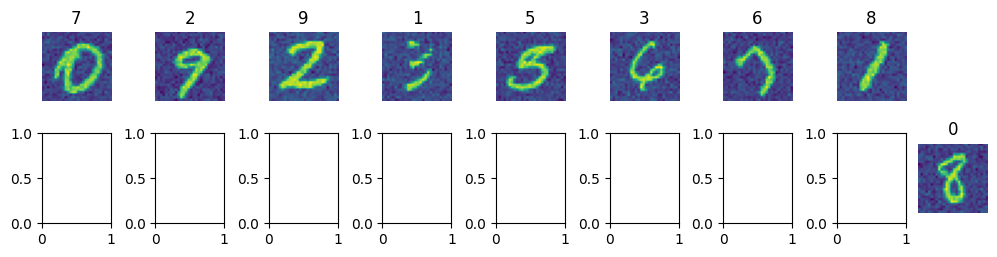

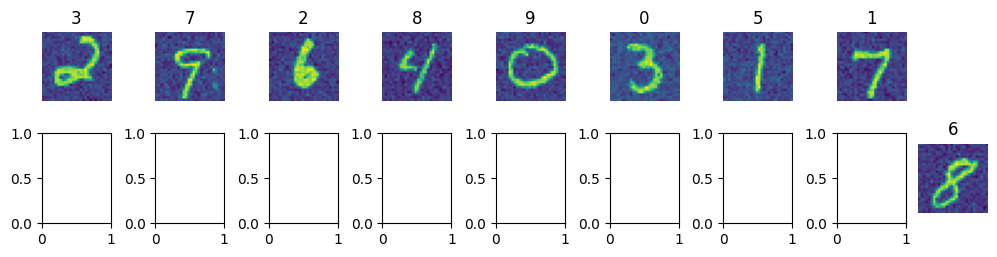

/home/bryanpu1/.conda/envs/icl_nc/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/bryanpu1/.conda/envs/icl_nc/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


('Accuracy: 0.0%\n', 'Query class in context ratio: 0.0')


In [12]:
in_weight_config_dict = copy.deepcopy(
    config_dict["learner_config"]["dataset_config"]
)
in_weight_config_dict["dataset_kwargs"]["task_config"]["num_sequences"] = num_test_tasks
in_weight_config_dict["dataset_kwargs"]["task_config"]["p_bursty"] = 0.0
in_weight_config_dict["dataset_kwargs"]["task_config"]["unique_classes"] = True
in_weight_config = parse_dict(in_weight_config_dict)

in_weight_acc = evaluate(
    exp_name=exp_name,
    eval_name="in_weight",
    dataset_config=in_weight_config,
    seed=test_data_seed,
    num_tasks=num_test_tasks,
    max_label=None,
    batch_size=num_samples_per_task,
    context_len=context_len,
    num_workers=num_workers,
    save=True,
    fixed_length=fixed_length,
    visualize=True,
)
print(in_weight_acc)

# In-context Evaluation
This uses heldout image classes.  
We consider the following evaluations:
1. **Complete out-of-distribution accuracy**: We use simply the heldout classes.  
We constrain the model output to only be the valid classes.

## Complete Out-of-distribution

In [13]:
ood_config_dict = copy.deepcopy(
    config_dict["learner_config"]["dataset_config"]
)
ood_config_dict["dataset_kwargs"]["train"] = False
ood_config_dict["dataset_kwargs"]["task_config"]["num_sequences"] = num_test_tasks
ood_config = parse_dict(ood_config_dict)

ood_acc = evaluate(
    exp_name=exp_name,
    eval_name="ood",
    dataset_config=ood_config,
    seed=test_data_seed,
    num_tasks=num_test_tasks,
    max_label=CONST_AUTO,
    batch_size=num_samples_per_task,
    context_len=context_len,
    num_workers=num_workers,
    save=True,
    visualize=False,
    vis_num_samples=3,
    fixed_length=fixed_length,
)
print(ood_acc)

Loading from /home/bryanpu1/projects/icl_nc/data/mnist_icl/omniglot_bursty-p_bursty_1.0-train_False-num_sequences_30-sequence_length_9-random_label_True-seed_1000.pkl


/home/bryanpu1/.conda/envs/icl_nc/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/bryanpu1/.conda/envs/icl_nc/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


('Accuracy: 90.0%\n', 'Query class in context ratio: 1.0')


## Variable-length Context Example

In [14]:
variable_length_context_config_dict = copy.deepcopy(
    config_dict["learner_config"]["dataset_config"]
)
variable_length_context_config_dict["dataset_kwargs"]["train"] = False
variable_length_context_config_dict["dataset_kwargs"]["task_config"]["num_sequences"] = num_test_tasks

variable_length_context_config_dict["dataset_wrapper"]["type"] = "ContextDataset"
variable_length_context_config_dict["dataset_wrapper"]["kwargs"]["include_query_class"] = True
variable_length_context_config = parse_dict(variable_length_context_config_dict)

variable_length_context_acc = evaluate(
    exp_name=exp_name,
    eval_name="variable_length_context",
    dataset_config=variable_length_context_config,
    seed=test_data_seed,
    num_tasks=num_test_tasks,
    max_label=CONST_AUTO,
    batch_size=context_len,
    context_len=context_len,
    num_workers=0,
    save=True,
    visualize=False,
    vis_num_samples=24,
    fixed_length=False,
)
print(variable_length_context_acc)

Loading from /home/bryanpu1/projects/icl_nc/data/mnist_icl/omniglot_bursty-p_bursty_1.0-train_False-num_sequences_30-sequence_length_9-random_label_True-seed_1000.pkl
('Accuracy: 92.5%\nContext Length: 1 - Accuracy: 96.66666666666667%\nContext Length: 2 - Accuracy: 100.0%\nContext Length: 3 - Accuracy: 93.33333333333333%\nContext Length: 4 - Accuracy: 93.33333333333333%\nContext Length: 5 - Accuracy: 90.0%\nContext Length: 6 - Accuracy: 93.33333333333333%\nContext Length: 7 - Accuracy: 90.0%\nContext Length: 8 - Accuracy: 83.33333333333334%\n', 'Query class in context ratio: 1.0')


## Hierarchy

In [15]:
hierarchy_config_dict = copy.deepcopy(
    config_dict["learner_config"]["dataset_config"]
)
hierarchy_config_dict["dataset_kwargs"]["train"] = False
hierarchy_config_dict["dataset_kwargs"]["remap"] = True
hierarchy_config_dict["dataset_kwargs"]["task_config"]["num_sequences"] = num_test_tasks
hierarchy_config = parse_dict(hierarchy_config_dict)

hierarchy_acc = evaluate(
    exp_name=exp_name,
    eval_name="hierarchy",
    dataset_config=hierarchy_config,
    seed=test_data_seed,
    num_tasks=num_test_tasks,
    max_label=CONST_AUTO,
    batch_size=num_samples_per_task,
    context_len=context_len,
    num_workers=num_workers,
    save=True,
    visualize=False,
    vis_num_samples=3,
    fixed_length=fixed_length,
)
print(hierarchy_acc)

Loading from /home/bryanpu1/projects/icl_nc/data/mnist_icl/omniglot_bursty-p_bursty_1.0-train_False-num_sequences_30-sequence_length_9-random_label_True-seed_1000.pkl


/home/bryanpu1/.conda/envs/icl_nc/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/bryanpu1/.conda/envs/icl_nc/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


('Accuracy: 90.0%\n', 'Query class in context ratio: 1.0')


### Enforce No Same Class Image in Context

Loading from /home/bryanpu1/projects/icl_nc/data/mnist_icl/omniglot_bursty-p_bursty_0.0-train_False-num_sequences_30-sequence_length_9-random_label_True-seed_1000.pkl


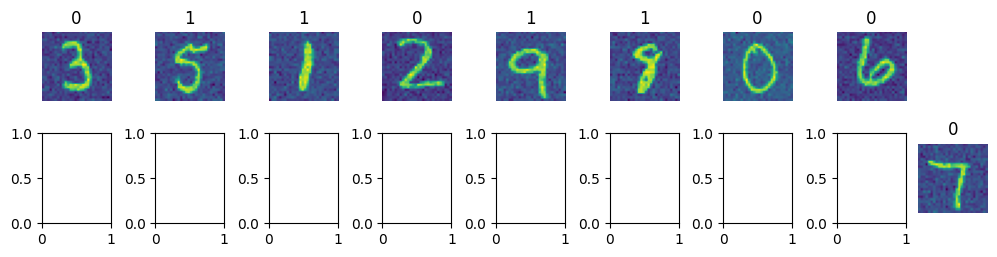

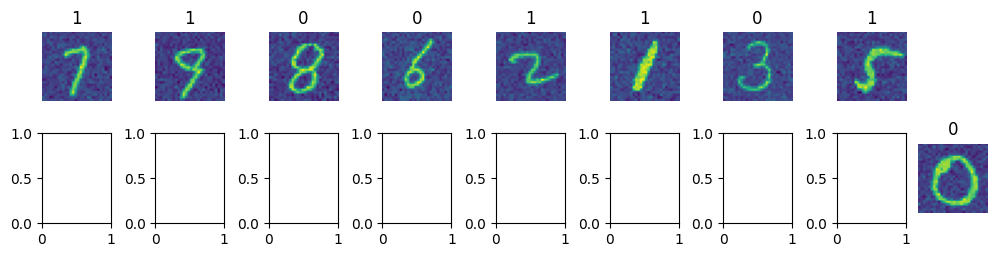

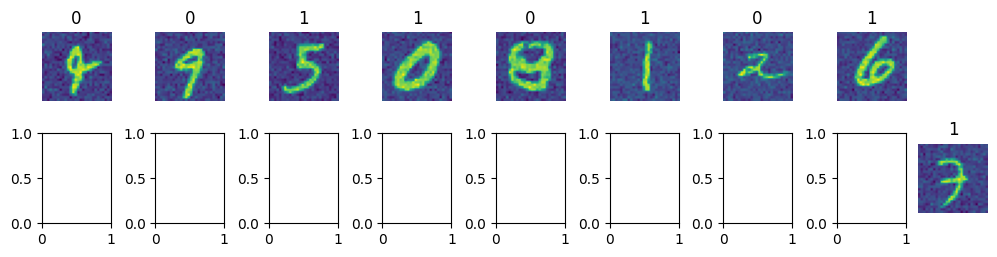

/home/bryanpu1/.conda/envs/icl_nc/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/bryanpu1/.conda/envs/icl_nc/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


('Accuracy: 36.666666666666664%\n', 'Query class in context ratio: 1.0')


In [16]:
unique_classes_hierarchy_config_dict = copy.deepcopy(
    config_dict["learner_config"]["dataset_config"]
)
unique_classes_hierarchy_config_dict["dataset_kwargs"]["train"] = False
unique_classes_hierarchy_config_dict["dataset_kwargs"]["remap"] = True
unique_classes_hierarchy_config_dict["dataset_kwargs"]["task_config"]["num_sequences"] = num_test_tasks
unique_classes_hierarchy_config_dict["dataset_kwargs"]["task_config"]["p_bursty"] = 0.0
unique_classes_hierarchy_config_dict["dataset_kwargs"]["task_config"]["unique_classes"] = True
unique_classes_hierarchy_config = parse_dict(unique_classes_hierarchy_config_dict)

unique_classes_hierarchy_acc = evaluate(
    exp_name=exp_name,
    eval_name="unique_classes_hierarchy",
    dataset_config=unique_classes_hierarchy_config,
    seed=test_data_seed,
    num_tasks=num_test_tasks,
    max_label=CONST_AUTO,
    batch_size=num_samples_per_task,
    context_len=context_len,
    num_workers=num_workers,
    save=True,
    visualize=True,
    vis_num_samples=3,
    fixed_length=fixed_length,
)
print(unique_classes_hierarchy_acc)

### Variable Length

In [17]:
variable_length_hierarchy_config_dict = copy.deepcopy(
    config_dict["learner_config"]["dataset_config"]
)
variable_length_hierarchy_config_dict["dataset_kwargs"]["train"] = False
variable_length_hierarchy_config_dict["dataset_kwargs"]["remap"] = True
variable_length_hierarchy_config_dict["dataset_kwargs"]["task_config"]["num_sequences"] = num_test_tasks

variable_length_hierarchy_config_dict["dataset_wrapper"]["type"] = "ContextDataset"
variable_length_hierarchy_config_dict["dataset_wrapper"]["kwargs"]["include_query_class"] = False
variable_length_hierarchy_config = parse_dict(variable_length_hierarchy_config_dict)

variable_length_hierarchy_acc = evaluate(
    exp_name=exp_name,
    eval_name="variable_length_hierarchy",
    dataset_config=variable_length_hierarchy_config,
    seed=test_data_seed,
    num_tasks=num_test_tasks,
    max_label=CONST_AUTO,
    batch_size=context_len,
    context_len=context_len,
    num_workers=0,
    save=True,
    visualize=False,
    vis_num_samples=24,
    fixed_length=False,
)
print(variable_length_hierarchy_acc)

Loading from /home/bryanpu1/projects/icl_nc/data/mnist_icl/omniglot_bursty-p_bursty_1.0-train_False-num_sequences_30-sequence_length_9-random_label_True-seed_1000.pkl
('Accuracy: 76.25%\nContext Length: 1 - Accuracy: 46.666666666666664%\nContext Length: 2 - Accuracy: 63.33333333333333%\nContext Length: 3 - Accuracy: 66.66666666666666%\nContext Length: 4 - Accuracy: 80.0%\nContext Length: 5 - Accuracy: 86.66666666666667%\nContext Length: 6 - Accuracy: 83.33333333333334%\nContext Length: 7 - Accuracy: 90.0%\nContext Length: 8 - Accuracy: 93.33333333333333%\n', 'Query class in context ratio: 0.9625')


# Final Results

In [18]:
all_accs = OrderedDict(
    pretraining=pretrain_acc,
    same_pretraining=same_pretraining_acc,
    in_weight=in_weight_acc,
    ood=ood_acc,
    variable_length_context=variable_length_context_acc,
    hierarchy=hierarchy_acc,
    unique_classes_hierarchy=unique_classes_hierarchy_acc,
    variable_length_hierarchy=variable_length_hierarchy_acc,
)

all_accs

OrderedDict([('pretraining',
              ('Accuracy: 93.0%\n', 'Query class in context ratio: 1.0')),
             ('same_pretraining',
              ('Accuracy: 93.33333333333333%\n',
               'Query class in context ratio: 1.0')),
             ('in_weight',
              ('Accuracy: 0.0%\n', 'Query class in context ratio: 0.0')),
             ('ood',
              ('Accuracy: 90.0%\n', 'Query class in context ratio: 1.0')),
             ('variable_length_context',
              ('Accuracy: 92.5%\nContext Length: 1 - Accuracy: 96.66666666666667%\nContext Length: 2 - Accuracy: 100.0%\nContext Length: 3 - Accuracy: 93.33333333333333%\nContext Length: 4 - Accuracy: 93.33333333333333%\nContext Length: 5 - Accuracy: 90.0%\nContext Length: 6 - Accuracy: 93.33333333333333%\nContext Length: 7 - Accuracy: 90.0%\nContext Length: 8 - Accuracy: 83.33333333333334%\n',
               'Query class in context ratio: 1.0')),
             ('hierarchy',
              ('Accuracy: 90.0%\n', 'Query